<a href="https://colab.research.google.com/github/kayaisacat/IAI5101_Assignment2/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('drive/My Drive/Colab Notebooks/concrete.csv')
df.shape

(1030, 9)

In [ ]:
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
df.dtypes

Cement                 float64
BlastFurnaceSlag       float64
FlyAsh                 float64
Water                  float64
Superplasticizer       float64
CoarseAggregate        float64
FineAggregate          float64
Age                      int64
CompressiveStrength    float64
dtype: object

In [ ]:
df.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


# A. EDA :

### Univariate Analysis: 
### 1.Build a histogram to show the distribution and central values of all the variables

In [ ]:
import nltk
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

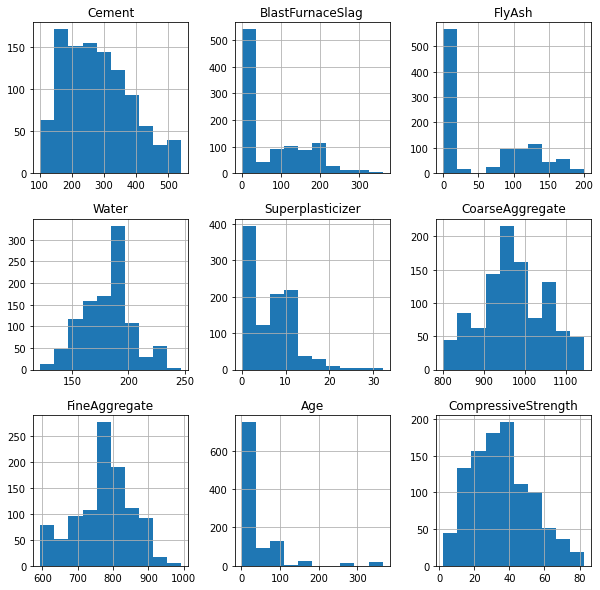

In [ ]:
df.hist(bins=10,figsize=(10,10))
plt.show()

### 2. Use a boxplot to determine if there are outliers in the variables

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

<AxesSubplot:xlabel='CompressiveStrength'>

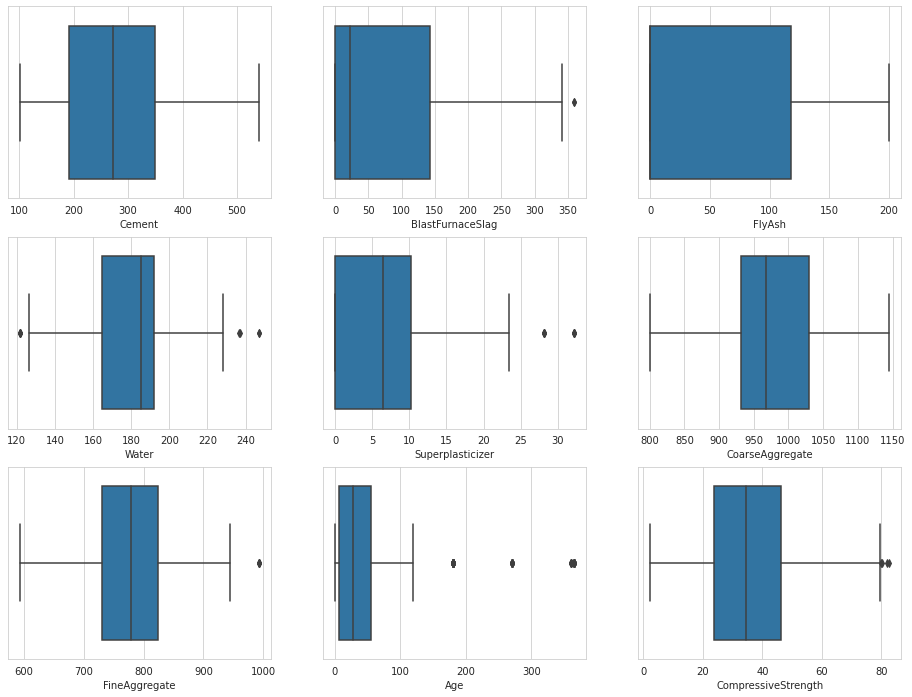

In [ ]:
plt.figure(figsize=(16,12))
sns.set_style(style='whitegrid')
plt.subplot(3,3,1)
sns.boxplot(x='Cement',data=df)
plt.subplot(3,3,2)
sns.boxplot(x='BlastFurnaceSlag',data=df)
plt.subplot(3,3,3)
sns.boxplot(x='FlyAsh',data=df)
plt.subplot(3,3,4)
sns.boxplot(x='Water',data=df)
plt.subplot(3,3,5)
sns.boxplot(x='Superplasticizer',data=df)
plt.subplot(3,3,6)
sns.boxplot(x='CoarseAggregate',data=df)
plt.subplot(3,3,7)
sns.boxplot(x='FineAggregate',data=df)
plt.subplot(3,3,8)
sns.boxplot(x='Age',data=df)
plt.subplot(3,3,9)
sns.boxplot(x='CompressiveStrength',data=df)

Blast Furnace Slag, Water , Super plasticizer, Fine Aggregate, Age, Compressive Strength
have outliners in dataset. 

### Multivariate Analysis:
### 1. Use a pair plot to determine the relationship and degree of relation between independent variables and between independent variables

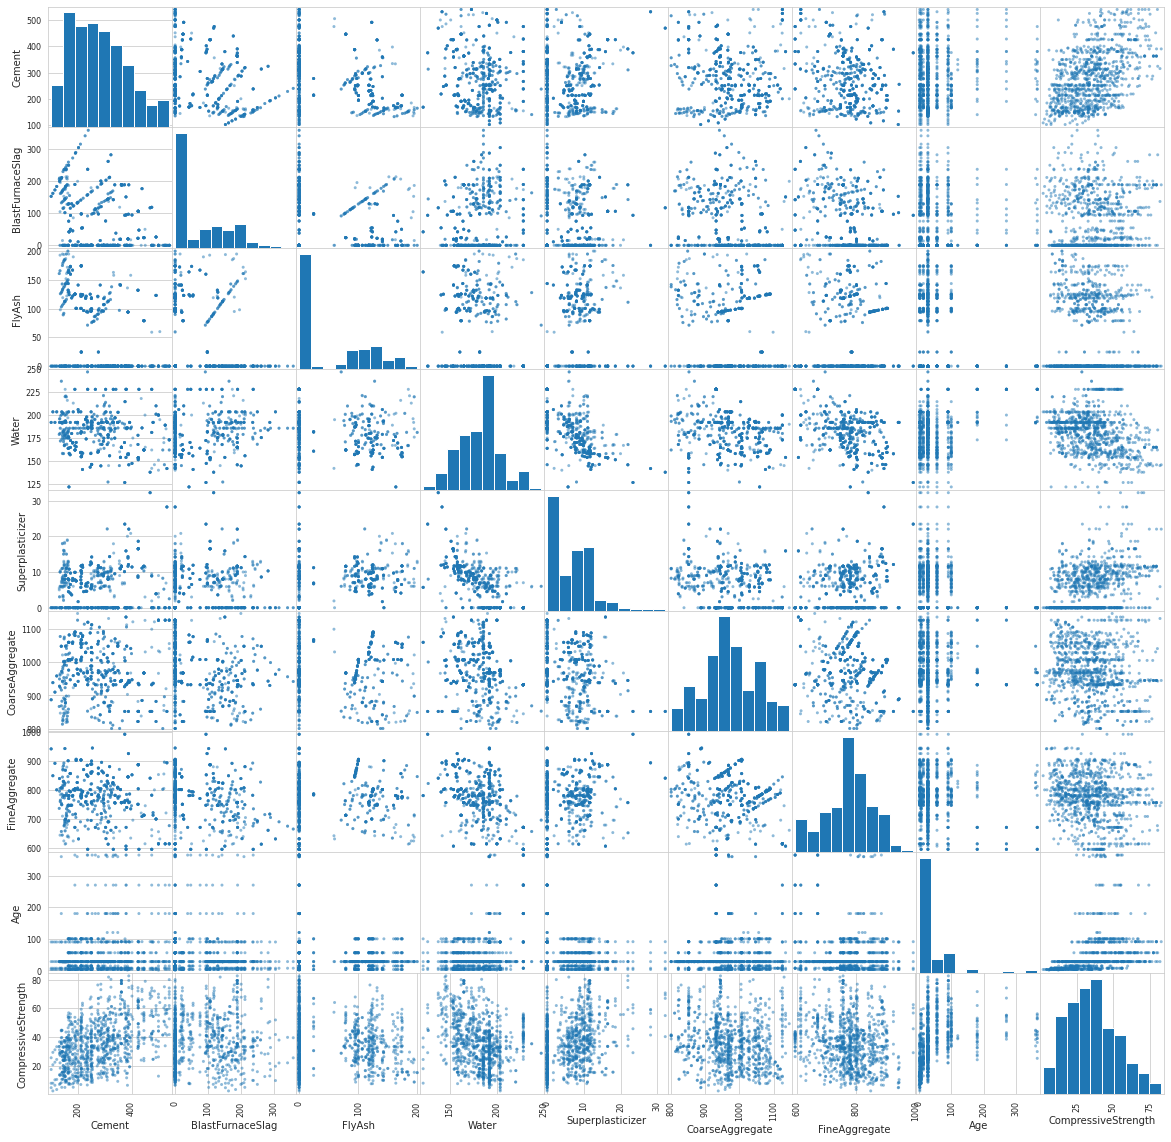

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df,figsize=(20,20));

### 2. Use a heatmap to check for correlation between predictor variables

In [ ]:
corr = df.corr()
print(corr);

                       Cement  BlastFurnaceSlag    FlyAsh     Water  \
Cement               1.000000         -0.275216 -0.397467 -0.081587   
BlastFurnaceSlag    -0.275216          1.000000 -0.323580  0.107252   
FlyAsh              -0.397467         -0.323580  1.000000 -0.256984   
Water               -0.081587          0.107252 -0.256984  1.000000   
Superplasticizer     0.092386          0.043270  0.377503 -0.657533   
CoarseAggregate     -0.109349         -0.283999 -0.009961 -0.182294   
FineAggregate       -0.222718         -0.281603  0.079108 -0.450661   
Age                  0.081946         -0.044246 -0.154371  0.277618   
CompressiveStrength  0.497832          0.134829 -0.105755 -0.289633   

                     Superplasticizer  CoarseAggregate  FineAggregate  \
Cement                       0.092386        -0.109349      -0.222718   
BlastFurnaceSlag             0.043270        -0.283999      -0.281603   
FlyAsh                       0.377503        -0.009961       0.079108 

<AxesSubplot:>

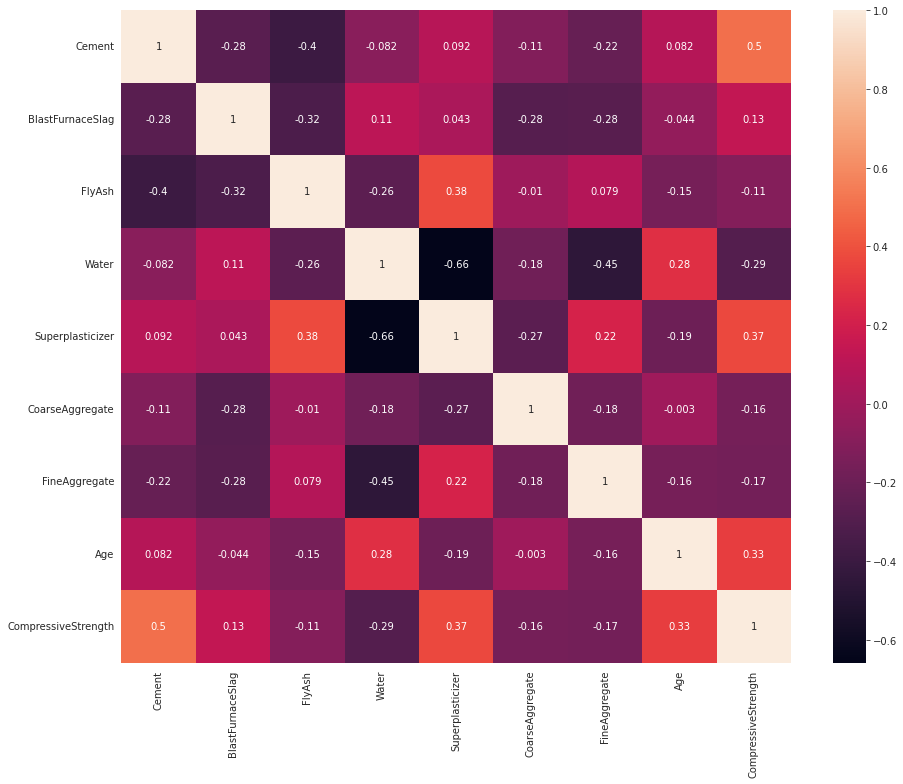

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot = True)

# II. Feature Engineering

#### • Ensure data is in the correct format for downstream processes
    Check for duplicates & missing values and drop, if present

In [ ]:
df.isnull().sum()

Cement                 0
BlastFurnaceSlag       0
FlyAsh                 0
Water                  0
Superplasticizer       0
CoarseAggregate        0
FineAggregate          0
Age                    0
CompressiveStrength    0
dtype: int64

In [ ]:
df.duplicated().sum()

25

In [ ]:
df.shape

(1030, 9)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(1005, 9)

#### Remove possible outliners in the dataset

( I define the outliners as greater than 75%quartile add the 1.5 Interquatrile range and less than 25% quartile subtract the 1.5 Interquatrile range)

In [ ]:
df.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.631343,72.043483,55.536318,182.075323,6.033234,974.376816,772.688259,45.856716,35.250378
std,104.344261,86.170807,64.207969,21.339334,5.919967,77.579667,80.340435,63.734692,16.284815
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,190.700000,0.000000,0.000000,166.600000,0.000000,932.000000,724.300000,7.000000,23.520000
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000,33.800000
75%,349.000000,142.500000,118.300000,192.900000,10.000000,1031.000000,822.200000,56.000000,44.870000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [ ]:
from sklearn.preprocessing import QuantileTransformer
quantile  = QuantileTransformer()
X = quantile.fit_transform(df)
df=quantile.transform(X)
df=pd.DataFrame(X)
df.columns =['Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water','Superplasticizer', 'CoarseAggregate','FineAggregate','Age','CompressiveStrength']
df.head()

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,1.000000,0.000000,0.0,0.201702,0.384384,0.755756,0.135135,0.522022,0.997038
1,1.000000,0.000000,0.0,0.201702,0.384384,0.822322,0.135135,0.522022,0.934263
2,0.717718,0.752753,0.0,0.969970,0.000000,0.260761,0.000000,0.974474,0.648511
3,0.717718,0.752753,0.0,0.969970,0.000000,0.260761,0.000000,1.000000,0.667668
4,0.271271,0.723724,0.0,0.689690,0.000000,0.567568,0.764765,0.983984,0.736737


In [ ]:
# #BlastFurnaceSlag
# df=df[df['BlastFurnaceSlag']<(142.5+1.5*(142.5-0))]
# #Water
# df=df[df['Water']<(192.9+1.5*(192.9-166.6))]
# df=df[df['Water']>(166.6-1.5*(192.9-166.6))]
# #Superplasticizer
# df=df[df['Superplasticizer']<(10+1.5*(10-0))]
# #FineAggregate
# df=df[df['FineAggregate']<(822.2+1.5*(822.2-724.3))]
# #Age
# df=df[df['Age']<(56+1.5*(56-7))]
# #CompressiveStrength
# df=df[df['CompressiveStrength']<(44.87+1.5*(44.87-23.52))]

<AxesSubplot:xlabel='CompressiveStrength'>

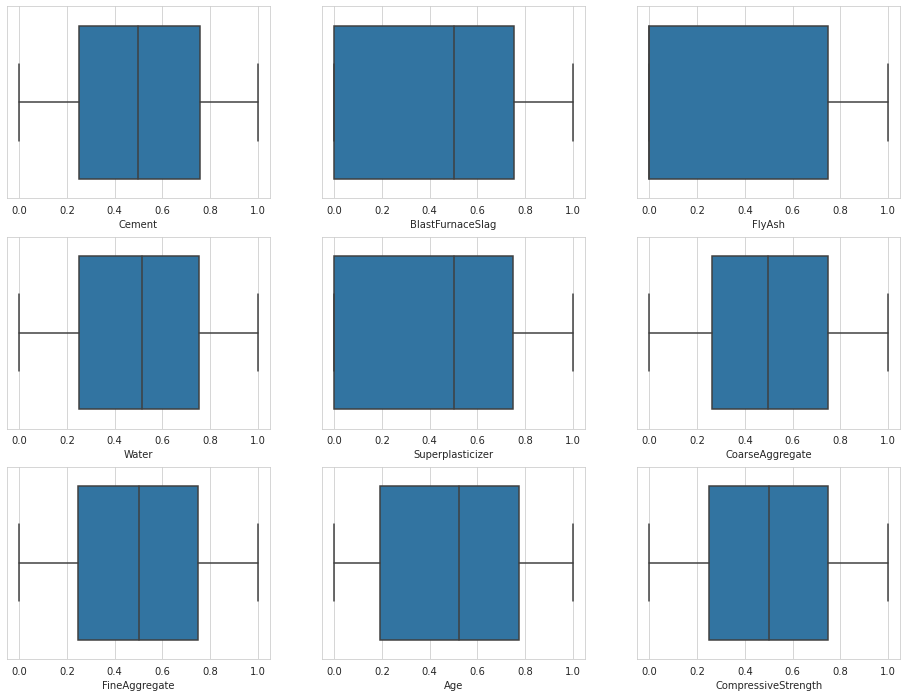

In [ ]:
plt.figure(figsize=(16,12))
sns.set_style(style='whitegrid')
plt.subplot(3,3,1)
sns.boxplot(x='Cement',data=df)
plt.subplot(3,3,2)
sns.boxplot(x='BlastFurnaceSlag',data=df)
plt.subplot(3,3,3)
sns.boxplot(x='FlyAsh',data=df)
plt.subplot(3,3,4)
sns.boxplot(x='Water',data=df)
plt.subplot(3,3,5)
sns.boxplot(x='Superplasticizer',data=df)
plt.subplot(3,3,6)
sns.boxplot(x='CoarseAggregate',data=df)
plt.subplot(3,3,7)
sns.boxplot(x='FineAggregate',data=df)
plt.subplot(3,3,8)
sns.boxplot(x='Age',data=df)
plt.subplot(3,3,9)
sns.boxplot(x='CompressiveStrength',data=df)

In [ ]:
df.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,0.500031,0.390797,0.355252,0.499995,0.429407,0.499998,0.499592,0.500092,0.500006
std,0.289210,0.383294,0.394361,0.288883,0.362737,0.289118,0.289887,0.277879,0.289110
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249750,0.000000,0.000000,0.249249,0.000000,0.260761,0.248248,0.190691,0.250250
50%,0.499833,0.500501,0.000000,0.515516,0.503003,0.494995,0.501502,0.522022,0.501001
75%,0.755756,0.752753,0.749750,0.752252,0.750250,0.749893,0.749249,0.773273,0.749765
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 3. Check for zero in the dataset and impute with the mean

In [ ]:
#checking for 0 values in columns
print(df[df['Cement']==0].shape[0])
print(df[df['BlastFurnaceSlag']==0].shape[0])
print(df[df['FlyAsh']==0].shape[0])
print(df[df['Water']==0].shape[0])
print(df[df['Superplasticizer']==0].shape[0])
print(df[df['CoarseAggregate']==0].shape[0])
print(df[df['FineAggregate']==0].shape[0])
print(df[df['Age']==0].shape[0])
print(df[df['CompressiveStrength']==0].shape[0])

4
470
541
5
378
4
30
2
1


In [ ]:
df['Cement']=df['Cement'].replace(0,df['Cement'].mean())#normal distribution
df['Water']=df['Water'].replace(0,df['Water'].mean())#normal distribution
df['CoarseAggregate']=df['CoarseAggregate'].replace(0,df['CoarseAggregate'].mean())#normal distribution
df['FineAggregate']=df['FineAggregate'].replace(0,df['FineAggregate'].mean())#normal distribution
df['CompressiveStrength']=df['CompressiveStrength'].replace(0,df['CompressiveStrength'].mean())#normal distribution

Some of the columns have a skewed distribution, so the mean is more affected by outliers than the median

In [ ]:
df['BlastFurnaceSlag']=df['BlastFurnaceSlag'].replace(0,df['BlastFurnaceSlag'].median())#skewed distribution
df['FlyAsh']=df['FlyAsh'].replace(0,df['FlyAsh'].median())#skewed distribution
df['Superplasticizer']=df['Superplasticizer'].replace(0,df['Superplasticizer'].median())#skewed distribution
df['Age']=df['Age'].replace(0,df['Age'].median())#skewed distribution

In [ ]:
#checking for 0 values in 3 columns
print(df[df['Cement']==0].shape[0])
print(df[df['BlastFurnaceSlag']==0].shape[0])
print(df[df['FlyAsh']==0].shape[0])
print(df[df['Water']==0].shape[0])
print(df[df['Superplasticizer']==0].shape[0])
print(df[df['CoarseAggregate']==0].shape[0])
print(df[df['FineAggregate']==0].shape[0])
print(df[df['Age']==0].shape[0])
print(df[df['CompressiveStrength']==0].shape[0])

0
0
541
0
0
0
0
0
0
